In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import grav_lens.preprocess as gp
from grav_lens.preprocess.filtering import process_batch_filters

from grav_lens.models.load_models import load_minmaxscaler, load_ipca_low
# Cargar el MinMaxScaler
minmaxscaler = load_minmaxscaler()
print(minmaxscaler)
# Cargar el modelo IPCA low
ipca_low = load_ipca_low()
print(ipca_low)


from grav_lens import get_datasets
max_files = 1400
batch_size = 64
home_data = os.path.join("..","data")

train_dataset, val_dataset, test_dataset = get_datasets(
    data_index=1,
    max_files=max_files,
    home=home_data,
    batch_size=batch_size,
    val_split=0.2,
    test_split=0.1,
)

for X_batch, y_batch in train_dataset.take(1):
    print(X_batch.shape)
    print(y_batch.shape)



IncrementalPCA(batch_size=64, n_components=64)
Using data folder: ..\data\1
(64, 128, 128, 3)
(64, 128, 128, 1)


# El proceso completo
De manera que tenemos las dos formas principales de datos
- gaussians (batch, 40, 5), con 40 el total de gaussianas, 5 el largo del vector de info: 
    meanx, meany, stdx, stdy, coef
- principal_components (batch, 64), con 64 coeficientes que representan cuanto hay de cada componente


In [2]:
N_GAUSS = 40

In [3]:
def preprocess_ybatch(y_batch, corte=2):
    low_batch, high_batch = process_batch_filters(y_batch)

    # se agregaron tecnicas de regularización
    gaussians = gp.gmm_batch_vectors(high_batch, n_gaussians_positive=N_GAUSS, n_gaussians_negative=0, 
                                    threshold=corte, n_points=750, scale=0.75, density_threshold=0.01)

    low_freq_stack = np.vstack([img.reshape(-1, 128*128) for img in low_batch]) #stack para el pca
    principal_components = ipca_low.transform(low_freq_stack)
    return [principal_components, gaussians]

In [4]:
for X_batch, y_batch in train_dataset.take(1):
    y_batch = minmaxscaler.transform(y_batch) # [0, 1] #escalar los datos

    print(X_batch.shape)
    print(y_batch.shape)
    
    y_process = preprocess_ybatch(y_batch, corte=3)


(64, 128, 128, 3)
(64, 128, 128, 1)


### Creacion del Modelo

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Función para construir el modelo CNN con dos ramas
def create_cnn_model(input_shape=(128, 128, 3), n_gaussians=N_GAUSS):
    """
    Crea un modelo CNN con dos ramas para predecir coeficientes de baja y alta frecuencia.

    Parámetros:
    -----------
    input_shape: tuple, opcional (default=(128, 128, 3))
        La forma de entrada de las imágenes.
    
    n_gaussians: int, opcional (default=40)
        Número de gaussianas en la predicción de alta frecuencia.

    Returns:
    --------
    model: tf.keras.Model
        Modelo de red neuronal con dos ramas: una para predecir coeficientes PCA de baja frecuencia
        y otra para predecir los parámetros de gaussianas de alta frecuencia.
    """
    
    # Definimos la entrada de la red
    input_img = layers.Input(shape=input_shape)
    trimmed_input = layers.Lambda(lambda x: x[..., :2])(input_img)  # Seleccionar solo los primeros dos canales

    # Primera capa CNN compartida con BatchNormalization y ReLU
    x = layers.Conv2D(32, (2, 2), padding='same', kernel_initializer='he_normal')(trimmed_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # le agregue esto para evitar un poco la varianza
    # x = layers.Conv2D(64, (2, 2),kernel_initializer='he_normal')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Activation('gelu')(x)
    # x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # División en dos ramas

    # Rama de baja frecuencia (lowfreq) - predicción de PCA
    #low_freq = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    low_freq = layers.Conv2D(64, (5, 5), kernel_initializer='he_normal')(x)
    #low_freq = layers.Dropout(0.001)(low_freq)
    low_freq = layers.BatchNormalization()(low_freq)
    low_freq = layers.ReLU()(low_freq)
    low_freq = layers.MaxPooling2D(pool_size=(2, 2))(low_freq)
    low_freq = layers.Flatten()(low_freq)
    #low_freq = layers.Dropout(0.01)(low_freq)

    low_freq = layers.Dense(128, kernel_initializer='he_normal',
             kernel_regularizer=tf.keras.regularizers.l1(0.0001))(low_freq)
    low_freq = layers.BatchNormalization()(low_freq)
    #low_freq = layers.LeakyReLU(negative_slope=0.2)(low_freq)
    # Usar 'linear' para que el output pueda ser cualquier valor
    low_freq_output = layers.Dense(128, activation='tanh')(low_freq)
    low_freq_output = layers.Lambda(lambda x: x * 5, name='lowfreq_output')(low_freq)


    # Rama de alta frecuencia (highfreq) - predicción de gaussianas
    high_freq = layers.Conv2D(32, (2, 2),kernel_initializer='he_normal')(x)  # Diferente kernel size
    high_freq = layers.Conv2D(32, (2, 2), padding='same', kernel_initializer='he_normal')(x)  # Diferente kernel size
    # high_freq = layers.BatchNormalization()(high_freq)
    high_freq = layers.LeakyReLU(negative_slope=0.2)(high_freq)
    high_freq = layers.MaxPooling2D(pool_size=(2, 2))(high_freq)
    high_freq = layers.Flatten()(high_freq)
    #high_freq = layers.Dropout(0.03)(high_freq)
    high_freq = layers.Dense(64, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(high_freq)
    high_freq = layers.Dense(64, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(high_freq)
    
    
    high_freq_output = layers.Dense(n_gaussians * 5, activation='linear', name='highfreq_output')(high_freq)  # 40 gaussianas * 5 parámetros
    high_freq_output = layers.Reshape((n_gaussians, 5))(high_freq_output)  # Reshape para que coincida con la salida gaussiana

    high_freq_output = layers.BatchNormalization()(high_freq_output)
    # Escalar los valores de salida de high_freq_output
    #mean_x_y = layers.Activation('softplus', name='mean_x_y')(high_freq_output[..., :2])
    
    # 0926 6pm: propongo escalar las medias para buscar distribuciones más unifomes
    mean_x_y = layers.Activation('sigmoid', name='mean_x_y')(high_freq_output[..., :2])
    mean_x_y = layers.Lambda(lambda x: x * 128, name='scaled_mean_x_y')(mean_x_y)

    std_x_y = layers.Activation('softplus', name='std_x_y')(high_freq_output[..., 2:4])
    std_x_y = layers.Lambda(lambda x: x * 10 + 1e-6, name='scaled_std_x_y')(std_x_y)

    weights = layers.Activation('sigmoid')(high_freq_output[..., 4])
    weights = layers.Lambda(lambda x: x * 0.1, name='weights')(weights)

    # Concatenar las salidas escaladas
    high_freq_output_scaled = layers.Concatenate(axis=-1)([mean_x_y, std_x_y, weights[..., tf.newaxis]])

    # Definir el modelo final con las dos ramas de salida
    model = models.Model(inputs=input_img, outputs=[low_freq_output, high_freq_output_scaled])

    return model

# Ejemplo de uso del modelo
cnn_model = create_cnn_model()
cnn_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 128, 128,  │          0 │ input_layer_5[0]… │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │        288 │ lambda_5[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 64, 64,    │          0 │ activation_12[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │      4,128 │ max_pooling2d_17… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 64, 64,    │          0 │ conv2d_25[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 32, 32,    │          0 │ leaky_re_lu_9[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 32768)     │          0 │ max_pooling2d_19… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 64)        │  2,097,216 │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 64)        │      4,160 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 60, 60,    │     51,264 │ max_pooling2d_17… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ highfreq_output     │ (None, 200)       │     13,000 │ dense_31[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 40, 5)     │          0 │ highfreq_output[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 60, 60,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 5)     │         20 │ reshape_5[0][0] 

 Total params: 9,543,900 (36.41 MB)

 Trainable params: 9,543,442 (36.41 MB)

 Non-trainable params: 458 (1.79 KB)

### Training

In [14]:
import tensorflow as tf
import numpy as np
import time

# callbacks
def prepare_callbacks(callbacks, model):
    if callbacks:
        for callback in callbacks:
            callback.set_model(model)
            callback.on_train_begin()
    return callbacks

def run_callbacks_on_epoch_end(callbacks, epoch, logs):
    if callbacks:
        for callback in callbacks:
            callback.on_epoch_end(epoch, logs=logs)

def run_callbacks_on_train_end(callbacks):
    if callbacks:
        for callback in callbacks:
            callback.on_train_end()


# Optimzier

# Función para inicializar el optimizador con un scheduler
def get_optimizer_with_scheduler(optimizer_name='sgd', initial_lr=0.001, scheduler=None, momentum=0.0, nesterov=False):
    """
    Inicializa el optimizador con un scheduler opcional.

    Parámetros:
        optimizer_name (str): Nombre del optimizador a utilizar ('adam' o 'sgd').
        initial_lr (float): Learning rate inicial.
        scheduler (tf.keras.optimizers.schedules, opcional): Scheduler para ajustar el learning rate durante el entrenamiento.
        momentum (float, opcional): Momento para el optimizador SGD (por defecto 0.0).
        nesterov (bool, opcional): Si usar Nesterov momentum para SGD (por defecto False).

    Retorna:
        tf.keras.optimizers.Optimizer: Optimizador inicializado.
    """
    # Si se proporciona un scheduler, usarlo como learning rate
    lr = scheduler if scheduler else initial_lr

    if optimizer_name.lower() == 'adam':
        return tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_name.lower() == 'sgd':
        return tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov)
    else:
        raise ValueError("Optimizer not recognized. Please use 'adam' or 'sgd'.")
# ------

# Definir un scheduler personalizado (opcional)
def cosine_scheduler(epoch, lr):
    max_epochs = 30
    return lr * (tf.math.cos(epoch * np.pi / max_epochs) + 1) / 2

# Función para calcular la pérdida y las métricas (solo MSE en este caso)
def calculate_losses(y_true, y_pred, mse_fn, entropy_penalty=True, entropy_weight=1e-2):
    mse_loss = mse_fn(y_true, y_pred)
    if entropy_penalty:
        entropy_penalty = -tf.reduce_mean(y_pred * tf.math.log(y_pred + 1e-6))
        mse_loss -= entropy_weight * entropy_penalty
    
    # gaussians y prediction: y_true, y_pred

    return mse_loss

# TODO
# probar normalización de principal components
# Función para ejecutar el entrenamiento de una época
def train_epoch(model, train_dataset, optimizer, mse_fn, print_steps, entropy_penalty=True, entropy_weight=1e-2):
    # Inicializar métricas
    train_mse_metric = tf.keras.metrics.Mean(name='train_mse')
    train_lowfreq_mse_metric = tf.keras.metrics.Mean(name='train_lowfreq_mse')
    train_highfreq_mse_metric = tf.keras.metrics.Mean(name='train_highfreq_mse')
    
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # Preprocesar y_batch
        principal_components, gaussians = preprocess_ybatch(y_batch_train)
        
        with tf.GradientTape() as tape:
            # El modelo debe devolver las dos ramas: lowfreq y highfreq
            lowfreq_pred, highfreq_pred = model(x_batch_train, training=True)
            
            # Calcular pérdidas separadas para ambas ramas
            mse_loss_low = mse_fn(principal_components, lowfreq_pred)

            #mse_loss_high = mse_fn(gaussians, highfreq_pred)
            mse_loss_high = calculate_losses(gaussians, highfreq_pred, mse_fn, entropy_penalty=entropy_penalty, entropy_weight=entropy_weight)
            
            # Sumar las pérdidas
            total_loss = 100*mse_loss_low + 0.01 * mse_loss_high

        # Aplicar gradientes
        grads = tape.gradient(total_loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Actualizar las métricas
        train_mse_metric(total_loss)
        train_lowfreq_mse_metric(mse_loss_low)
        train_highfreq_mse_metric(mse_loss_high)

        # Mostrar progreso
        if step % print_steps == 0:
            print(f'Step {step}: Total MSE = {train_mse_metric.result().numpy()}, '
                  f'LowFreq MSE = {train_lowfreq_mse_metric.result().numpy()}, '
                  f'HighFreq MSE = {train_highfreq_mse_metric.result().numpy()}')

    return train_mse_metric.result().numpy(), train_lowfreq_mse_metric.result().numpy(), train_highfreq_mse_metric.result().numpy()


# Función para ejecutar la validación
def validate_epoch(model, val_dataset, mse_fn):
    val_mse_metric = tf.keras.metrics.Mean(name='val_mse')
    val_lowfreq_mse_metric = tf.keras.metrics.Mean(name='val_lowfreq_mse')
    val_highfreq_mse_metric = tf.keras.metrics.Mean(name='val_highfreq_mse')

    for val_x, val_y in val_dataset:
        # Preprocesar y_batch
        principal_components, gaussians = preprocess_ybatch(val_y)
        
        # El modelo debe devolver las dos ramas: lowfreq y highfreq
        lowfreq_pred, highfreq_pred = model(val_x, training=False)
        
        # Calcular pérdidas separadas para ambas ramas
        mse_loss_low = mse_fn(principal_components, lowfreq_pred)
        mse_loss_high = mse_fn(gaussians, highfreq_pred)
        
        # Sumar las pérdidas
        total_loss = mse_loss_low + mse_loss_high

        # Actualizar las métricas
        val_mse_metric(total_loss)
        val_lowfreq_mse_metric(mse_loss_low)
        val_highfreq_mse_metric(mse_loss_high)

    return val_mse_metric.result().numpy(), val_lowfreq_mse_metric.result().numpy(), val_highfreq_mse_metric.result().numpy()

# Función para reiniciar métricas
def reset_metrics(metric):
    metric.reset_state()

# Función principal para entrenar el modelo
def train_model(epochs, model, train_dataset, val_dataset, optimizer, mse_fn, print_steps, callbacks=None):
    # Inicializar las métricas
    history = {
        'loss': [], 'val_loss': [],
        'lowfreq_mse': [], 'highfreq_mse': [],
        'val_lowfreq_mse': [], 'val_highfreq_mse': []
    }

    # Preparar callbacks
    callbacks = prepare_callbacks(callbacks, model)

    # Iterar sobre las épocas
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        # Entrenar una época
        train_loss, train_lowfreq_mse, train_highfreq_mse = train_epoch(
            model, train_dataset, optimizer, mse_fn, print_steps)
        history['loss'].append(train_loss)
        history['lowfreq_mse'].append(train_lowfreq_mse)
        history['highfreq_mse'].append(train_highfreq_mse)

        # Validación
        val_loss, val_lowfreq_mse, val_highfreq_mse = validate_epoch(model, val_dataset, mse_fn)
        history['val_loss'].append(val_loss)
        history['val_lowfreq_mse'].append(val_lowfreq_mse)
        history['val_highfreq_mse'].append(val_highfreq_mse)

        # Mostrar progreso de la época completa
        print(f'Epoch {epoch + 1}/{epochs} - '
              f'Loss: {train_loss:.4f}, LowFreq MSE: {train_lowfreq_mse:.4f}, HighFreq MSE: {train_highfreq_mse:.4f} - '
              f'Val Loss: {val_loss:.4f}, Val LowFreq MSE: {val_lowfreq_mse:.4f}, Val HighFreq MSE: {val_highfreq_mse:.4f}')

        # Ejecutar callbacks al final de la época
        logs = {'loss': train_loss, 'val_loss': val_loss}
        run_callbacks_on_epoch_end(callbacks, epoch, logs)

    # Ejecutar callbacks al final del entrenamiento
    run_callbacks_on_train_end(callbacks)

    return history



In [15]:
# Early stopping callback basado en val_mse
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode="min",
    patience=5,  # Número de épocas sin mejora antes de detener
    restore_best_weights=True  # Restaurar los mejores pesos
)


callbacks = [
    early_stopping,
]

In [16]:
# Tamaño del buffer para mezclar los datos (debe ser mayor o igual al tamaño del dataset completo para una mejor aleatorización)
buffer_size = 1000

# Crear un dataset aleatorio tomando una muestra de 10 elementos
input_train_dataset = train_dataset.shuffle(buffer_size).take(20)


# --------------------------------
# Definir el optimizador
# yo utilizo SGD pues mi PC demoraria más con Adam
# En casos de mayor potencia Adam converge más rapido

scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,  # Número de pasos antes de llegar a lr mínimo
    alpha=1e-4  # Valor final del learning rate (porcentaje del learning rate inicial)
)

# scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


optimizer = get_optimizer_with_scheduler(optimizer_name='adam', initial_lr=1e-3, scheduler=scheduler)


# ---------------------------
# Definir la función de pérdida MSE
mse_fn = tf.keras.losses.MeanSquaredError()

# Entrenar el modelo
history = train_model(
    epochs=6,                        # Número de épocas de entrenamiento
    model=cnn_model,                  # Modelo CNN que has definido con dos ramas
    train_dataset=input_train_dataset,      # Dataset de entrenamiento preprocesado
    val_dataset=val_dataset,          # Dataset de validación preprocesado
    optimizer=optimizer,              # Optimizador con el scheduler
    mse_fn=mse_fn,                    # Función de pérdida (MSE)
    print_steps=3,                   # Mostrar progreso cada steps
    callbacks=callbacks               # Callbacks, incluyendo EarlyStopping y TimeStopping
)



Epoch 1/6


InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [64,64] vs. [64,128] [Op:Sub] name: 

In [9]:
history_general = history

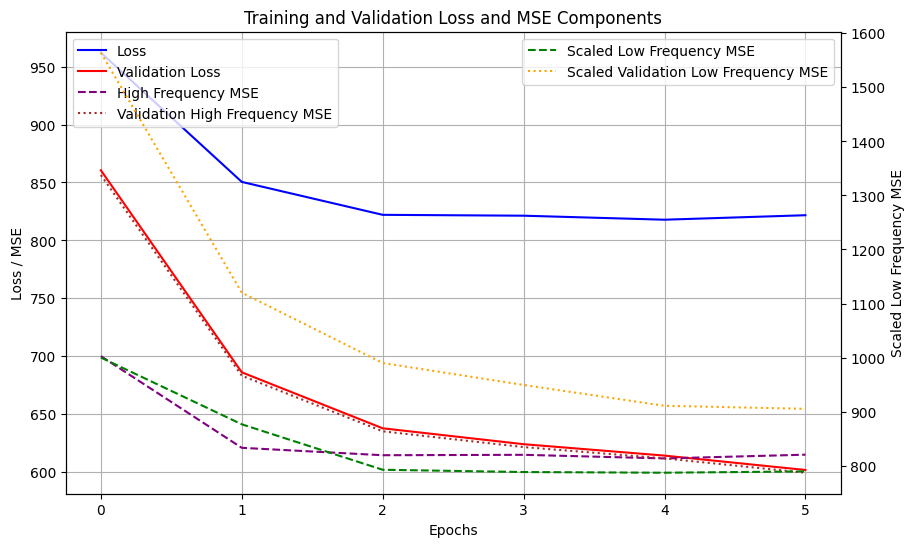

In [10]:
import matplotlib.ticker as ticker

# Scaling factor for low frequency MSE
scaling_factor = 1000 / max(history_general['lowfreq_mse'])

# Scaled low frequency MSE
scaled_lowfreq_mse = [x * scaling_factor for x in history_general['lowfreq_mse']]
scaled_val_lowfreq_mse = [x * scaling_factor for x in history_general['val_lowfreq_mse']]

# Plotting the data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total loss and validation loss with solid lines
ax1.plot(history_general['loss'], label='Loss', color='blue', linestyle='-')
ax1.plot(history_general['val_loss'], label='Validation Loss', color='red', linestyle='-')

# Plot other components with dashed lines
ax1.plot(history_general['highfreq_mse'], label='High Frequency MSE', linestyle='--', color='purple')
ax1.plot(history_general['val_highfreq_mse'], label='Validation High Frequency MSE', linestyle=':', color='brown')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss / MSE')
ax1.set_title('Training and Validation Loss and MSE Components')
ax1.legend(loc='upper left')
ax1.grid(True)

# Create a second y-axis for the scaled low frequency MSE
ax2 = ax1.twinx()
ax2.plot(scaled_lowfreq_mse, label='Scaled Low Frequency MSE', linestyle='--', color='green')
ax2.plot(scaled_val_lowfreq_mse, label='Scaled Validation Low Frequency MSE', linestyle=':', color='orange')

# Set the right y-axis ticks and label
ax2.set_ylabel('Scaled Low Frequency MSE')
ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax2.legend(loc='upper right')

plt.show()

### reconstruccion

In [11]:
from grav_lens.preprocess.gmm import reconstruct_image_from_gmm, reconstruct_lowfreq_from_pca, reconstruct_highfreq_from_gmm, reconstruct_batch_images


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


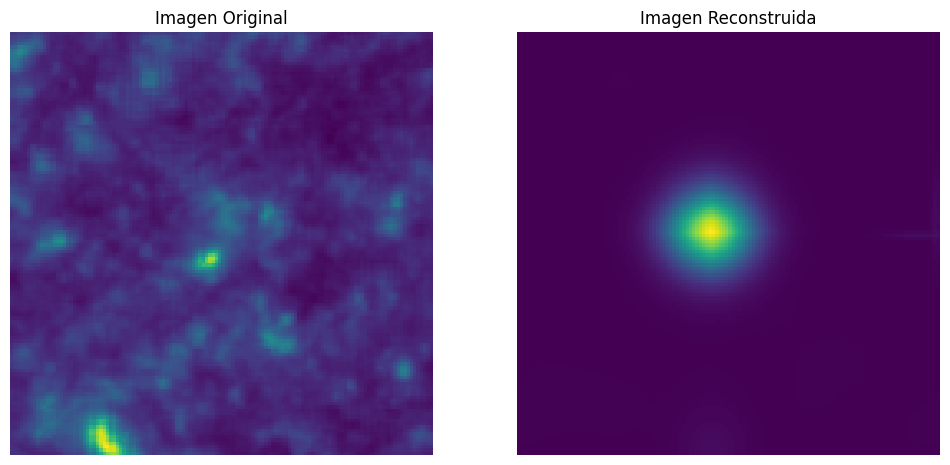

In [12]:
for X_batch, y_batch in val_dataset.take(1):
    predictions = cnn_model.predict(X_batch)
    # Obtener el tamaño del batch
    batch_size = X_batch.shape[0]

    low_batch, high_batch = process_batch_filters(y_batch)
    real_gaussians = gp.gmm_batch_vectors(high_batch, 40, 0, 1)

    # Reconstruir imágenes de baja y alta frecuencia
    reconstructed_images = reconstruct_batch_images(*predictions, batch_size, ipca_low)

gp.plot_comparison(y_batch[1,:,:,0],reconstructed_images[1,:,:,0])

In [13]:


import numpy as np

def gaussians_histogram(predictions_example):
    # Suponiendo que `predictions[1]` es la salida de las gaussianas con la forma (64, 40, 5)
    # Crear un histograma para cada componente
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    component_names = ['mean_x', 'mean_y', 'std_x', 'std_y', 'weight']

    for i in range(5):
        axes[i].hist(predictions_example[:, :, i].flatten(), bins=50, alpha=0.7, color='blue')
        axes[i].set_title(f'Histogram of {component_names[i]}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

Las predicciones de la parte de las Gaussianas

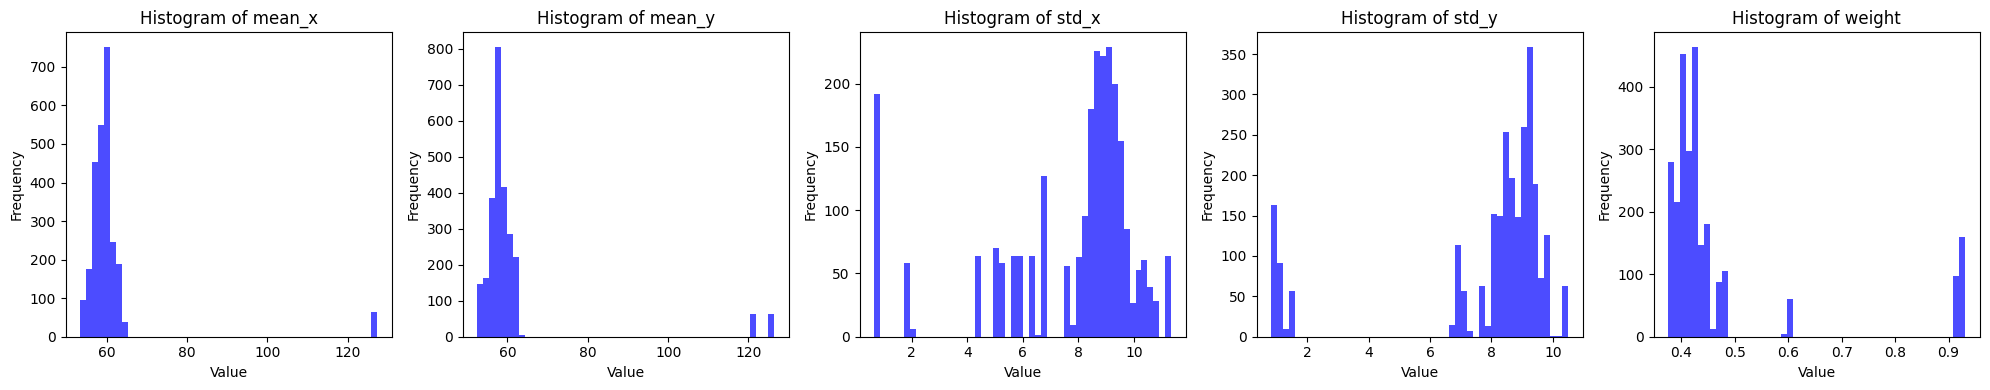

In [14]:
gaussians_histogram(predictions_example = predictions[1])    

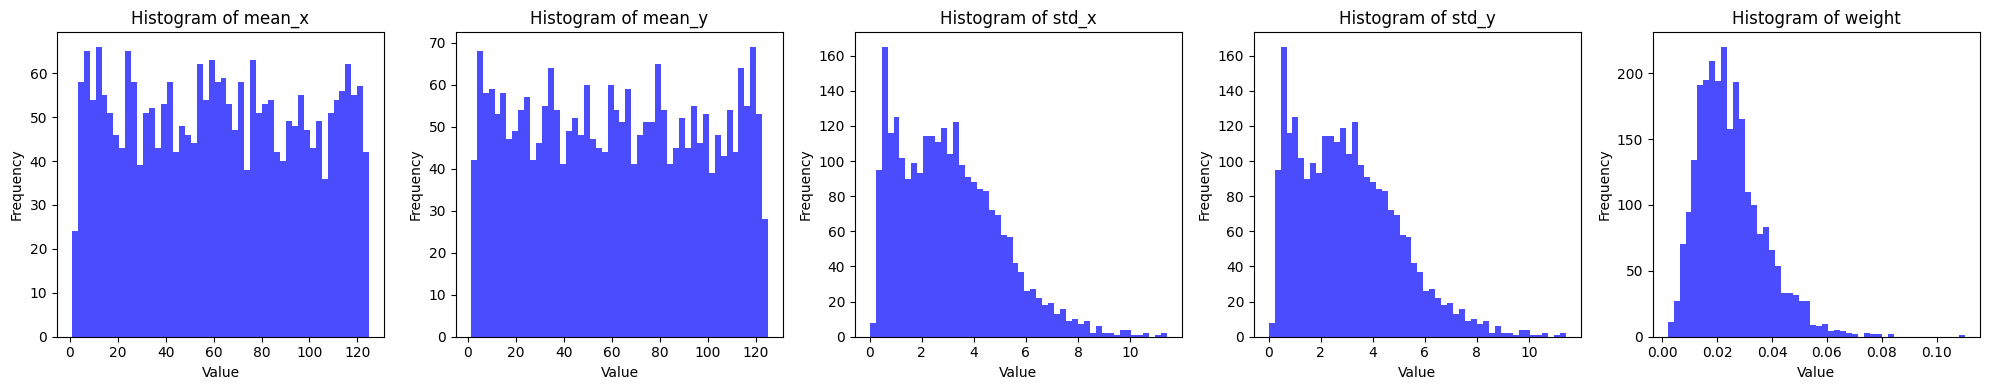

In [15]:
gaussians_histogram(predictions_example = real_gaussians)    

El caso de los weights para los datos de baja oscilacion

In [ ]:
plt.hist(predictions[0].flatten(), bins=50, alpha=0.7, color='blue')


In [ ]:
low_freq_stack = np.vstack([img.reshape(-1, 128*128) for img in low_batch]) #stack para el pca
principal_components = ipca_low.transform(low_freq_stack)

plt.hist(principal_components.flatten(), bins=50, alpha=0.7, color='blue')


Guardar el modelo

In [16]:
cnn_model.save('model_0926_b.keras')